# 나랑 닮은 연예인 찾기
-----

## 모듈 임포트
-----

In [113]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import pandas as pd
import face_recognition
import os

## 1. 사진 모으기
-----

### 1. 정수희 퍼실님이 공유해주신 한국 유명인 얼굴 데이터 셋을 활용하였다.
[정수희 퍼실님 agit 게시글](https://drive.google.com/file/d/1SCNlkW3l9bzsGhzFVk8DmNdfq9D-sey2/view?usp=sharing)

l


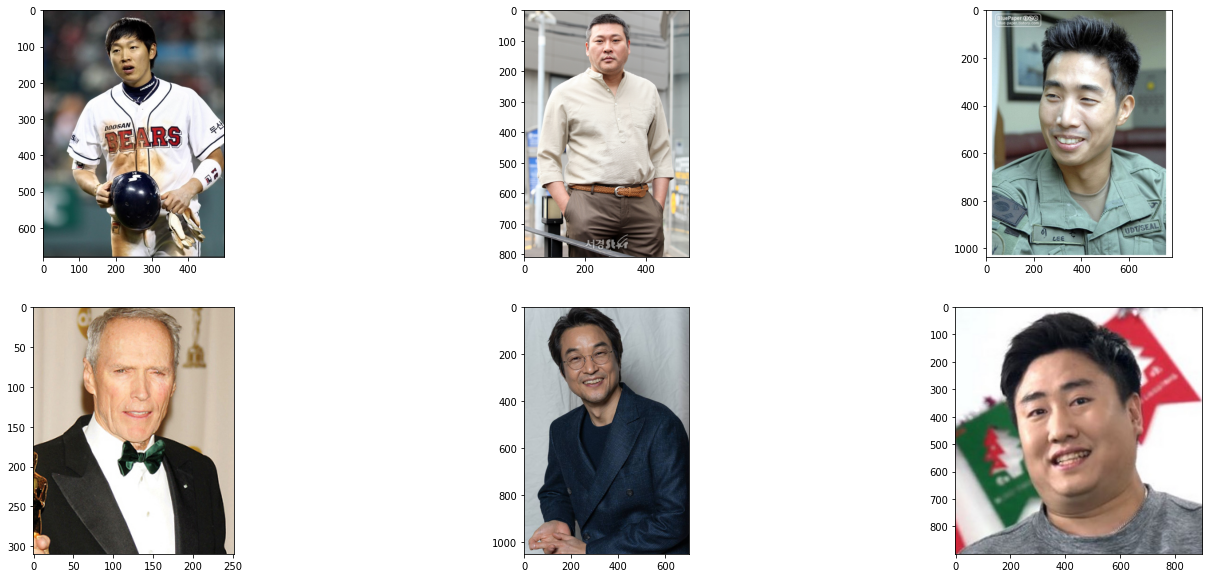

In [17]:
dir_path = os.getenv('HOME')+'/aiffel/nearest_face/celebrity'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list)[5])

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
  image = img.imread(dir_path+'/'+file_list[i])
  ax.imshow(image)
plt.show()

fig.tight_layout()

## 2. 얼굴영역 자르기
-----

In [250]:
def get_cropped_face(image_file, **kwargs):
    image_path = image_file
    if 'my' in kwargs.keys() and kwargs['my'] is True:
        directory_path = '/aiffel/aiffel/nearest_face/my'
    else: 
        if 'cropped' in kewarts.key() and kwargs['cropped'] is True:
            directory_path = dir_path  
        else: directory_path = cropped_path
    image = face_recognition.load_image_file(directory_path+'/'+image_path)    
    face_location = face_recognition.face_locations(image)
    cropped_face = None
    if face_location:
        a, b, c, d = face_location[0]
        cropped_face = image[a:c,d:b,:]
    return cropped_face

In [179]:
%matplotlib inline

image_files = os.listdir(dir_path)
cropped_path = f'{os.getenv("HOME")}/aiffel/nearest_face/cropped_celebrity/'
print(f'images for cropping:{len(image_files)}')

need_change = {'jpeg':'jpg'} # 변경이 필요한 확장자와 변경할 확장자명을 dictionary에 저장
for image_file in os.listdir(dir_path):
    if os.path.isfile(cropped_path+'/'+image_file):
        continue
    face = get_cropped_face(image_file)
    if str(type(face)) == "<class 'numpy.ndarray'>":
        pillow_image = Image.fromarray(face)
        extension = image_file[image_file.find('.')+1:] # 이미지의 확장자명 할당
        if  extension in need_change.keys():
            image_file = image_file[:image_file.find('.')+1]+need_change[extension] # '이미지이름.' + '변경할 확장자명' 
        pillow_image.save(cropped_path+'/'+image_file)

print('cropped images:',len(os.listdir(cropped_path)))     

images for cropping:282
cropped images: 280


## 3. 얼굴영역의 임베딩 추출하기
-----

In [228]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

def get_face_embedding_dict():
    file_list = os.listdir(cropped_path)
    embedding_dict = {}
    print(f'file_list: {len(file_list)}EA')
    for file in file_list:
        face = get_cropped_face(file, cropped=True)
        try:
            embedding_dict[file[:file.find('.')]] = get_face_embedding(face)[0]
        except:
            print(f'get_face_embedding(face)[0]에서 IndexError 에러발생')
            continue
    print(f'embedding_dict: {len(embedding_dict.keys())}EA')                
    return embedding_dict

In [180]:
embedding_dict = get_face_embedding_dict()

file_list: 280EA
정우성.jpg
정수빈.jpg
최무성.jpg
류승룡.jpg
벤 에플렉.jpg
클린트 이스트우드.jpg
옥냥이.jpg
한석규.jpg
유희열.jpg
철면수심.jpg
트와이스미나.jpg
다니엘 크레이그.jpg
드웨인 존슨.jpg
피어스 브로스넌.jpg
장원영.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
이동휘.jpg
태양.jpg
김학범.jpg
박찬호.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
이대형.jpg
박나래.jpg
주진모(올드).jpg
이동국.jpg
우기.jpg
박찬욱.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
레인보우재경.jpg
최민식.jpg
레드벨벳웬디.jpg
김고은.jpg
켄 정.jpg
조인성.jpg
한효주.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
아린.jpg
제프리 힌턴.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
clinton.jpg
이재용.jpg
찬열.jpg
이승철.jpg
이안 굿펠로우.jpg
차승원.jpg
지수.jpg
이대호.jpg
태연.jpg
고창석.jpg
박재범.jpg
이근대위.jpg
정민철.jpg
수지.jpg
케이.jpg
서강준.jpg
크리스 에반스.jpg
조원희.jpg
주호민.jpg
차범근.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
류진.jpg
잭 스페이더.jpg
시우민.jpg
러블리즈지수.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
장성호.jpg
솔라.jpg
biden.jpg
이용진.jpg
류승범.jpg
get_face_embedding(face)[0]에서 IndexError 에러발생
김연우.jpg
슬리피.jpg
꽈두룹.jpg
지디.jpg
조정석.jpg
안재홍.jpg
김구라.jpg
조승우.jpg

In [181]:
embedding_dict['아이즈원김채원']

array([-0.0795245 , -0.01494443,  0.06406848, -0.10234819, -0.11636536,
       -0.0497067 , -0.08156206, -0.06364114,  0.15357509, -0.10354065,
        0.21343592, -0.08065557, -0.26495373, -0.03456224, -0.05075052,
        0.23031238, -0.14851226, -0.115526  , -0.05924044,  0.01407062,
        0.01625848,  0.02854577,  0.05175017,  0.04358076, -0.13501295,
       -0.34333223, -0.10034198, -0.02043454, -0.12544622, -0.06561843,
       -0.01983082,  0.07138813, -0.16988678,  0.00187836,  0.07217894,
        0.11995577, -0.02248729, -0.09636493,  0.1351845 , -0.00608754,
       -0.31914538,  0.0203278 ,  0.10450958,  0.23336264,  0.16554947,
        0.01188913, -0.00807976, -0.16390382,  0.10922118, -0.15616256,
        0.06929652,  0.10492902,  0.08201275, -0.01251916,  0.02179188,
       -0.09599459,  0.01988124,  0.22409117, -0.164235  , -0.02333179,
        0.11311875, -0.06170096, -0.02397387, -0.15519755,  0.20063411,
        0.11285731, -0.16750465, -0.22860387,  0.09278087, -0.14

## 4. 모은 연예인들과 비교하기
-----

In [278]:
def get_distance(my_embedding, name2):
    return np.linalg.norm(my_embedding-embedding_dict[name2], ord=2)

def get_sort_key_func(my_embedding):
    def get_distance_from_my_embedding(name2):
        return get_distance(my_embedding, name2)
    return get_distance_from_my_embedding

def get_nearest_face(my_embedding, top_rank=1):
    sort_key_func = get_sort_key_func(my_embedding)
    top_list = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))[:top_rank+1]
    dir_path = os.getenv('HOME')+'/aiffel/nearest_face/celebrity'
    print(f'[닮은 꼴 연예인 top{top_rank}]')
    for i in range(1, top_rank+1):
        distance = np.linalg.norm(top_list[i][1]-top_list[0][1], ord=2)
        print(f'순위 {i}: 이름({top_list[i][0]}), 거리({distance})')
        file_name = top_list[i][0] +'.jpg'
        try:
            plt.imshow(img.imread(dir_path+'/'+file_name))
            plt.show()
        except:
            file_name = file_name[:file_name.find('.')+1]+'jpeg'
            plt.imshow(img.imread(f'{dir_path}/{file_name}'))
            plt.show()        

In [235]:
def my_face_embedding(my_image):
    image_path = my_image
    face = get_cropped_face(image_path, my=True)
    my_embedding = get_face_embedding(face)[0]
    return my_embedding

In [271]:
def main():
    my_image = input('불러올 사진의 이름를 입력하세요.(jpg,jpeg만!) \n')
    my_embedding = my_face_embedding(my_image)
    print('내 이미지')
    plt.imshow(img.imread(f'/aiffel/aiffel/nearest_face/my/{my_image}'))
    plt.show()
    get_nearest_face(my_embedding, 5)

불러올 사진의 이름를 입력하세요.(jpg,jpeg만!) 
my_face.jpg
내 이미지


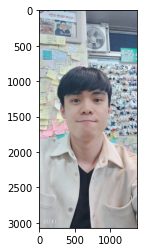

[닮은 꼴 연예인 top5]
순위 1: 이름(슈가), 거리(0.5067994530091864)


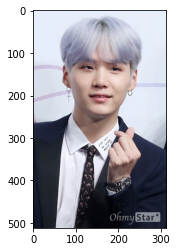

순위 2: 이름(이용진), 거리(0.5006397658985219)


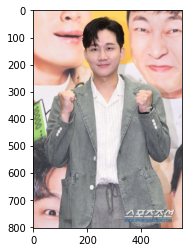

순위 3: 이름(이대형), 거리(0.48950463026051044)


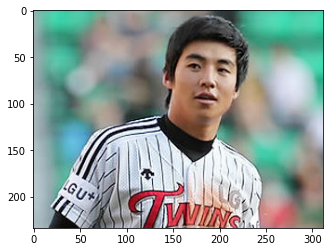

순위 4: 이름(개코), 거리(0.515309612001345)


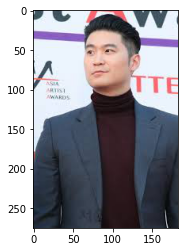

순위 5: 이름(박정민), 거리(0.5764394651952983)


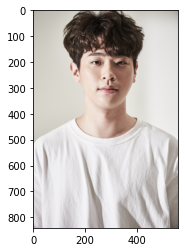

In [279]:
main()

## 5. 다양한 시각화 시도해보기
-----